# Import Libraries

In [1]:
import os, sys, json, cv2, time, glob, gc, datetime
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tqdm import tqdm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, TensorBoard, ModelCheckpoint
from tensorflow.keras.regularizers import l1, l2, l1_l2
from sklearn.model_selection import train_test_split
from kerastuner import HyperModel, Hyperband
from kerastuner.tuners import RandomSearch
from keras.layers import BatchNormalization

C:\Users\WenShen\AppData\Local\Temp\ipykernel_29688\422802593.py:15: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel, Hyperband


# Configurations

In [2]:
# Setup the paths to train and test images
TRAIN_DIR = './global-wheat-detection/train/'
TEST_DIR = './global-wheat-detection/test/'
TRAIN_CSV_PATH = './global-wheat-detection/train.csv'
AUG_SAVE_DIR = './global-wheat-detection/augmented_images/'
SAVE_PATH = 'models/CustomCNN/'
CHECKPOINT_DIR = 'models/CustomCNN/checkpoints/'

EPOCHS = 20
IMG_SIZE = 256

# Create a directory if it doesn't exist
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)
if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)

# Data Loading

In [3]:
df = pd.read_csv('./df_augment.csv')
# df = pd.read_csv('./df_full.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 443477 entries, 0 to 443476
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   image_id  443477 non-null  object 
 1   x         443477 non-null  float64
 2   y         443477 non-null  float64
 3   w         443477 non-null  float64
 4   h         443477 non-null  float64
 5   source    443477 non-null  object 
dtypes: float64(4), object(2)
memory usage: 20.3+ MB


In [4]:
def load_image_and_bbox(image_id, bbox):
    image = tf.io.read_file(image_id)
    image = tf.image.decode_jpeg(image, channels=3)
    original_size = tf.shape(image)[:2]
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    # bbox = bbox / (original_size[0] / IMG_SIZE)
    return image, bbox

def parse_dataframe(df, TRAIN_DIR=TRAIN_DIR, AUG_SAVE_DIR=AUG_SAVE_DIR):
    image_ids = []
    for i, row in tqdm(df.iterrows(), total=len(df), desc='Parsing dataframe and image path'):
        image_id = row['image_id']
        ori_image_path = f'{TRAIN_DIR}/{image_id}.jpg'
        augmented_image_path = f'{AUG_SAVE_DIR}/{image_id}.jpg'
        if os.path.exists(ori_image_path):
            image_path = ori_image_path
        else:
            image_path = augmented_image_path
        image_ids.append(image_path)
    bboxes = df[['x', 'y', 'w', 'h']].values
    return image_ids, bboxes

def create_dataset(image_paths, bboxes, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, bboxes))
    dataset = dataset.map(lambda x, y: load_image_and_bbox(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

image_ids, bboxes = parse_dataframe(df)


Parsing dataframe and image path: 100%|██████████| 443477/443477 [00:20<00:00, 21123.05it/s]


In [5]:
# Split the dataset
train_paths, test_paths, train_bboxes, test_bboxes = train_test_split(image_ids, bboxes, test_size=0.4, random_state=42)
test_paths, val_paths, test_bboxes, val_bboxes = train_test_split(test_paths, test_bboxes, test_size=0.5, random_state=42)

# Create TensorFlow Datasets
train_dataset = create_dataset(train_paths, train_bboxes)
val_dataset = create_dataset(val_paths, val_bboxes)
test_dataset = create_dataset(test_paths, test_bboxes)

train_dataset = train_dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
val_dataset = val_dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
test_dataset = test_dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))


In [6]:
for images, bboxes in train_dataset.take(1):
    print(images.shape, bboxes.shape, len(train_dataset))
for images, bboxes in test_dataset.take(1):
    print(images.shape, bboxes.shape, len(test_dataset))
for images, bboxes in val_dataset.take(1):
    print(images.shape, bboxes.shape, len(val_dataset))

(32, 256, 256, 3) (32, 4) 8316
(32, 256, 256, 3) (32, 4) 2772
(32, 256, 256, 3) (32, 4) 2772


# Model building

In [7]:
def plot_metrics(history):
    # Extract metrics from the history object
    accuracy = history.history.get('accuracy', [])
    val_accuracy = history.history.get('val_accuracy', [])
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])
    mae = history.history.get('mae', [])
    val_mae = history.history.get('val_mae', [])
    mse = history.history.get('mse', [])  # Add this line
    val_mse = history.history.get('val_mse', [])  # Add this line
    rmse = history.history.get('rmse', [])
    val_rmse = history.history.get('val_rmse', [])
    learning_rate = history.history.get('lr', [])
    epochs = range(1, len(accuracy) + 1)

    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 3, 1)
    plt.plot(accuracy)
    plt.plot(val_accuracy)
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.xticks(epochs)
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(2, 3, 2)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xticks(epochs)
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation MAE values
    plt.subplot(2, 3, 3)
    plt.plot(mae)
    plt.plot(val_mae)
    plt.title('Model MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.xticks(epochs)
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation MSE values
    plt.subplot(2, 3, 4)
    plt.plot(mse)
    plt.plot(val_mse)
    plt.title('Model MSE') 
    plt.ylabel('MSE')  
    plt.xlabel('Epoch')
    plt.xticks(epochs)
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot learning rate
    if learning_rate:
        plt.subplot(2, 3, 5)
        plt.plot(learning_rate)
        plt.title('Learning Rate')
        plt.ylabel('Learning Rate')
        plt.xlabel('Epoch')

    plt.tight_layout()
    plt.show()

## Custom CNN 1

In [8]:
class CustomCNNModel1:
    def __init__(self, input_shape=(IMG_SIZE, IMG_SIZE, 3)):
        self.input_shape = input_shape
        self.model = self.build_model()

    def build_model(self):
        # Check for GPU availability
        if tf.config.list_physical_devices('GPU'):
            device = '/GPU:0'
        else:
            device = '/CPU:0'
        print(f'Using device: {device}')
        with tf.device(device):
            model = Sequential()
            
            # First Convolutional Block
            model.add(Conv2D(32, (3, 3), activation='relu', input_shape=self.input_shape))
            model.add(MaxPooling2D((2, 2)))

            # Second Convolutional Block
            model.add(Conv2D(64, (3, 3), activation='relu'))
            model.add(MaxPooling2D((2, 2)))

            # Third Convolutional Block
            model.add(Conv2D(128, (3, 3), activation='relu'))
            model.add(MaxPooling2D((2, 2)))

            # Global Average Pooling instead of Flattening
            model.add(GlobalAveragePooling2D())

            # Fully Connected Layer with Dropout
            model.add(Dense(512, activation='relu'))
            model.add(Dropout(0.5))

            # Output Layer
            model.add(Dense(4, activation='linear'))  # Output layer with 4 units for bounding box coordinates (whxy)
        return model

    def compile_model(self):
        self.model.compile(optimizer='adam', loss='mse', metrics=['accuracy', 'mae', 'mse', tf.keras.metrics.RootMeanSquaredError(name='rmse')])

    def train(self, train_dataset, val_dataset, epochs=EPOCHS, checkpoint_dir=CHECKPOINT_DIR):
        # Callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
        checkpoint_callback = ModelCheckpoint(filepath=os.path.join(checkpoint_dir, 'custom_cnn_model1.keras'), save_weights_only=False, monitor='val_loss', save_best_only=True, mode='min')
        log_dir = os.path.join('logs', 'CustomCNN1', 'fit', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
        tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
        # lr_scheduler = LearningRateScheduler(self.step_decay_schedule(initial_lr=0.1, decay_factor=0.5, step_size=10))
        history = self.model.fit(train_dataset, validation_data=val_dataset, epochs=epochs,
                                 callbacks=[early_stopping, reduce_lr, checkpoint_callback, tensorboard_callback])
        return history

    def evaluate(self, test_dataset):
        results = self.model.evaluate(test_dataset, verbose=0)
        loss, acc, mse, mae, rmse = results
        # rmse = np.sqrt(mse)
        lr = self.model.optimizer.learning_rate.numpy()
        print(f'Testing Loss: {loss:.4f}, Accuracy: {acc:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, Learning Rate: {lr:.4f}')
        return {
            'loss': loss,
            'accuracy': acc,
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'learning_rate': lr
        }
        
    def step_decay_schedule(self, initial_lr=0.1, decay_factor=0.5, step_size=10):
        def schedule(epoch):
            return initial_lr * (decay_factor ** (epoch // step_size))
        return schedule
    
    def save(self, path):
        self.model.save(path)

# Initialize the CustomCNNModel class
custom_cnn_model1 = CustomCNNModel1(input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Compile the model
custom_cnn_model1.compile_model()

custom_cnn_model1.model.summary()

Using device: /GPU:0
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None

In [9]:
# Train the model
history = custom_cnn_model1.train(train_dataset, val_dataset, epochs=EPOCHS)

# Evaluate the model on the test set
test_loss = custom_cnn_model1.evaluate(test_dataset)

Epoch 1/20
8316/8316 [==============================] - 611s 71ms/step - loss: 25810.0684 - accuracy: 0.4901 - mae: 100.7102 - mse: 25810.0684 - rmse: 160.6551 - val_loss: 24335.3887 - val_accuracy: 0.4884 - val_mae: 97.8628 - val_mse: 24335.3887 - val_rmse: 155.9980 - lr: 0.0010
Epoch 2/20
2093/8316 [======>.......................] - ETA: 6:43 - loss: 24792.4004 - accuracy: 0.4885 - mae: 98.9587 - mse: 24792.4004 - rmse: 157.4560

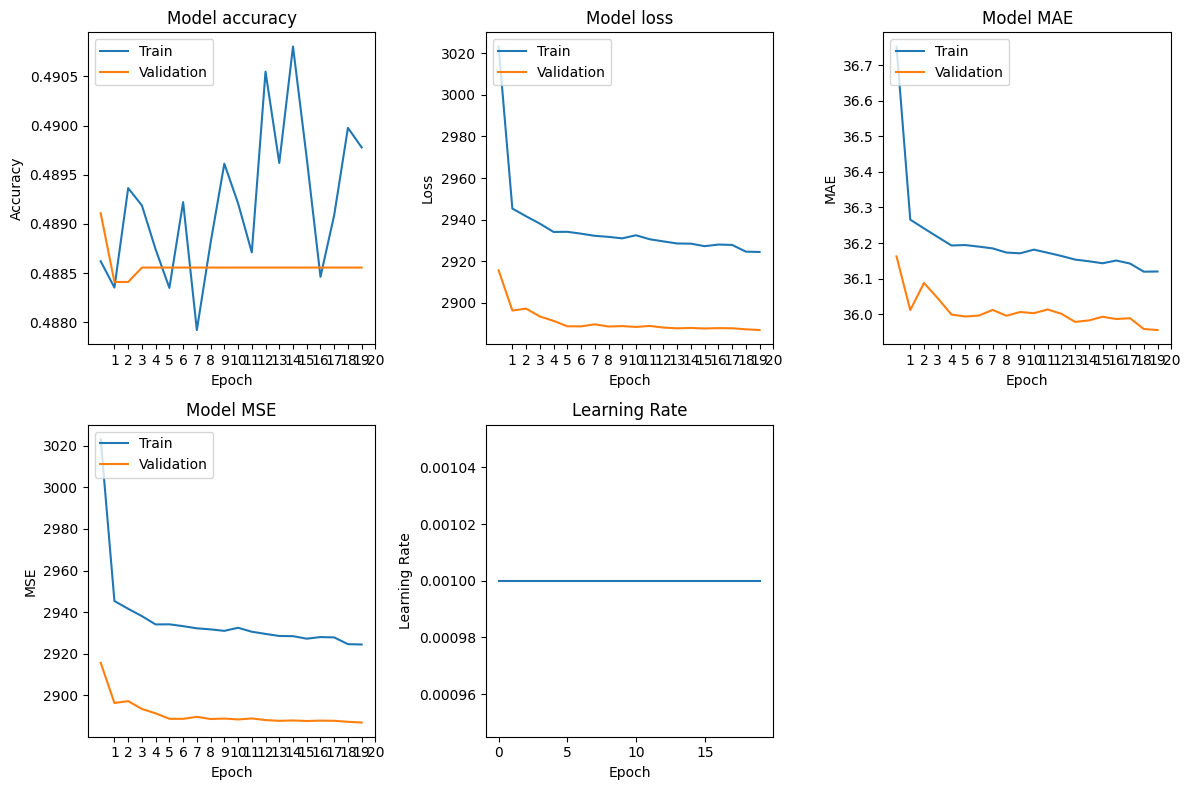

In [ ]:
plot_metrics(history)

In [11]:
# Save the entire model
custom_cnn_model1.save(SAVE_PATH + 'custom_cnn_model1.keras')

In [12]:
# Load the model from a file
# custom_cnn_model1 = tf.keras.models.load_model(SAVE_PATH + 'custom_cnn_model1.keras')
gc.collect()

22258

## Custom CNN 2

In [13]:
class CustomCNNModel2:
    def __init__(self, input_shape=(IMG_SIZE, IMG_SIZE, 3)):
        self.input_shape = input_shape
        self.model = self.build_model()

    def build_model(self):
        # Check for GPU availability
        if tf.config.list_physical_devices('GPU'):
            device = '/GPU:0'
        else:
            device = '/CPU:0'
        print(f'Using device: {device}')
        
        with tf.device(device):
            model = Sequential()
            
            # First Convolutional Block
            model.add(Conv2D(32, (3, 3), activation='relu', input_shape=self.input_shape))
            model.add(MaxPooling2D((2, 2)))

            # Second Convolutional Block
            model.add(Conv2D(64, (3, 3), activation='relu'))
            model.add(MaxPooling2D((2, 2)))

            # Third Convolutional Block
            model.add(Conv2D(128, (3, 3), activation='relu'))
            model.add(MaxPooling2D((2, 2)))

            # Fourth Convolutional Block
            model.add(Conv2D(256, (3, 3), activation='relu'))
            model.add(MaxPooling2D((2, 2)))

            # Global Average Pooling instead of Flattening
            model.add(GlobalAveragePooling2D())

            # Fully Connected Layer with Dropout
            model.add(Dense(512, activation='relu'))
            model.add(Dropout(0.5))

            # Output Layer
            model.add(Dense(4, activation='linear'))  # Output layer with 4 units for bounding box coordinates (whxy)
        return model

    def compile_model(self):
        self.model.compile(optimizer='adam', loss='mse', metrics=['accuracy', 'mae', 'mse', tf.keras.metrics.RootMeanSquaredError(name='rmse')])

    def train(self, train_dataset, val_dataset, epochs=EPOCHS, checkpoint_dir=CHECKPOINT_DIR):
        # Callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
        checkpoint_callback = ModelCheckpoint(filepath=os.path.join(checkpoint_dir, 'custom_cnn_model2.keras'), save_weights_only=False, monitor='val_loss', save_best_only=True, mode='min')
        log_dir = os.path.join('logs', 'CustomCNN2', 'fit', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
        tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
        # lr_scheduler = LearningRateScheduler(self.step_decay_schedule(initial_lr=0.1, decay_factor=0.5, step_size=10))
        history = self.model.fit(train_dataset, validation_data=val_dataset, epochs=epochs,
                                 callbacks=[early_stopping, reduce_lr, checkpoint_callback, tensorboard_callback])
        return history

    def evaluate(self, test_dataset):
        results = self.model.evaluate(test_dataset, verbose=0)
        loss, acc, mse, mae, rmse = results
        # rmse = np.sqrt(mse)
        lr = self.model.optimizer.learning_rate.numpy()
        print(f'Testing Loss: {loss:.4f}, Accuracy: {acc:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, Learning Rate: {lr:.4f}')
        return {
            'loss': loss,
            'accuracy': acc,
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'learning_rate': lr
        }
    
    def save(self, path):
        self.model.save(path)

    def step_decay_schedule(self, initial_lr=0.1, decay_factor=0.5, step_size=10):
        def schedule(epoch):
            return initial_lr * (decay_factor ** (epoch // step_size))
        return schedule

# Initialize the CustomCNNModel class
custom_cnn_model2 = CustomCNNModel2(input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Compile the model
custom_cnn_model2.compile_model()

custom_cnn_model2.model.summary()

Using device: /GPU:0
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (No

In [14]:
# Train the model
history2 = custom_cnn_model2.train(train_dataset, val_dataset, epochs=EPOCHS)

# Evaluate the model on the test set
test_loss = custom_cnn_model2.evaluate(test_dataset)

Epoch 1/20
8316/8316 [==============================] - 728s 87ms/step - loss: 3028.0190 - accuracy: 0.4895 - mae: 36.7842 - mse: 3028.0190 - rmse: 55.0274 - val_loss: 2936.7983 - val_accuracy: 0.4884 - val_mae: 36.2243 - val_mse: 2936.7983 - val_rmse: 54.1922 - lr: 0.0010
Epoch 2/20
8316/8316 [==============================] - 667s 80ms/step - loss: 2959.4363 - accuracy: 0.4904 - mae: 36.3352 - mse: 2959.4363 - rmse: 54.4007 - val_loss: 2911.9016 - val_accuracy: 0.4886 - val_mae: 36.1848 - val_mse: 2911.9016 - val_rmse: 53.9620 - lr: 0.0010
Epoch 3/20
8316/8316 [==============================] - 651s 78ms/step - loss: 2956.3474 - accuracy: 0.4887 - mae: 36.3106 - mse: 2956.3474 - rmse: 54.3723 - val_loss: 2907.9019 - val_accuracy: 0.4884 - val_mae: 36.1248 - val_mse: 2907.9019 - val_rmse: 53.9250 - lr: 0.0010
Epoch 4/20
8316/8316 [==============================] - 660s 79ms/step - loss: 2950.9187 - accuracy: 0.4886 - mae: 36.2792 - mse: 2950.9187 - rmse: 54.3224 - val_loss: 2907.2554 

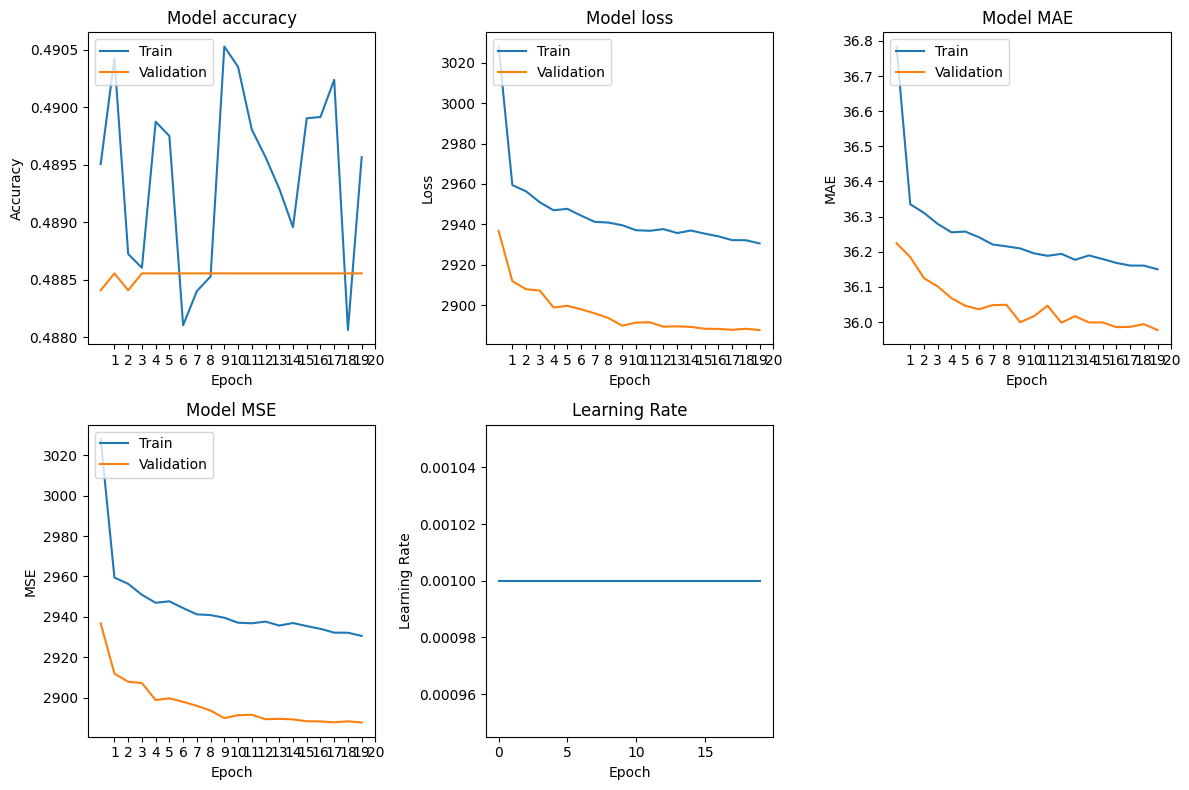

In [15]:
plot_metrics(history2)

In [16]:
# Save the entire model
custom_cnn_model2.save(SAVE_PATH + 'custom_cnn_model2.keras')

In [17]:
# Load the model from a file
# custom_cnn_model2 = tf.keras.models.load_model(SAVE_PATH + 'custom_cnn_model2.keras')
gc.collect()

22459

## Custom CNN 3

In [18]:
class CustomCNNModel3:
    def __init__(self, input_shape=(IMG_SIZE, IMG_SIZE, 3)):
        self.input_shape = input_shape
        self.model = self.build_model()

    def build_model(self):
        # Check for GPU availability
        if tf.config.list_physical_devices('GPU'):
            device = '/GPU:0'
        else:
            device = '/CPU:0'
        print(f'Using device: {device}')
        
        with tf.device(device):
            model = Sequential()
            
            # First Convolutional Block
            model.add(Conv2D(32, (3, 3), activation='relu', input_shape=self.input_shape))
            model.add(BatchNormalization())
            model.add(MaxPooling2D((2, 2)))

            # Second Convolutional Block
            model.add(Conv2D(64, (3, 3), activation='relu'))
            model.add(BatchNormalization())
            model.add(MaxPooling2D((2, 2)))

            # Third Convolutional Block
            model.add(Conv2D(128, (3, 3), activation='relu'))
            model.add(BatchNormalization())
            model.add(MaxPooling2D((2, 2)))

            # Fourth Convolutional Block
            model.add(Conv2D(256, (3, 3), activation='relu'))
            model.add(BatchNormalization())
            model.add(MaxPooling2D((2, 2)))

            # Fifth Convolutional Block
            model.add(Conv2D(512, (3, 3), activation='relu'))
            model.add(BatchNormalization())
            model.add(MaxPooling2D((2, 2)))
            
            # Sixth Convolutional Block
            model.add(Conv2D(1024, (3, 3), activation='relu'))
            model.add(BatchNormalization())
            model.add(MaxPooling2D((2, 2)))

            # Global Average Pooling instead of Flattening
            model.add(GlobalAveragePooling2D())

            # Fully Connected Layer with Dropout
            model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
            model.add(Dropout(0.5))

            # Output Layer
            model.add(Dense(4, activation='linear'))  # Output layer with 4 units for bounding box coordinates (whxy)
        return model

    def compile_model(self):
        self.model.compile(optimizer='adam', loss='mse', metrics=['accuracy', 'mae', 'mse', tf.keras.metrics.RootMeanSquaredError(name='rmse')])

    def train(self, train_dataset, val_dataset, epochs=EPOCHS, checkpoint_dir=CHECKPOINT_DIR):
        # Callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
        checkpoint_callback = ModelCheckpoint(filepath=os.path.join(checkpoint_dir, 'custom_cnn_model3.keras'), save_weights_only=False, monitor='val_loss', save_best_only=True, mode='min')
        log_dir = os.path.join('logs', 'CustomCNN3', 'fit', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
        tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
        # lr_scheduler = LearningRateScheduler(self.step_decay_schedule(initial_lr=0.1, decay_factor=0.5, step_size=10))
        history = self.model.fit(train_dataset, validation_data=val_dataset, epochs=epochs,
                                 callbacks=[early_stopping, reduce_lr, checkpoint_callback, tensorboard_callback])
        return history

    def evaluate(self, test_dataset):
        results = self.model.evaluate(test_dataset, verbose=0)
        loss, acc, mse, mae, rmse = results
        # rmse = np.sqrt(mse)
        lr = self.model.optimizer.learning_rate.numpy()
        print(f'Testing Loss: {loss:.4f}, Accuracy: {acc:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, Learning Rate: {lr:.4f}')
        return {
            'loss': loss,
            'accuracy': acc,
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'learning_rate': lr
        }
    
    def save(self, path):
        self.model.save(path)
        
    def step_decay_schedule(self, initial_lr=0.1, decay_factor=0.5, step_size=10):
        def schedule(epoch):
            return initial_lr * (decay_factor ** (epoch // step_size))
        return schedule

# Initialize the CustomCNNModel class
custom_cnn_model3 = CustomCNNModel3(input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Compile the model
custom_cnn_model3.compile_model()

custom_cnn_model3.model.summary()

Using device: /GPU:0
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 125, 125, 64)     256       
 hNormalization)                                                 
                                 

In [19]:
# Train the model
history3 = custom_cnn_model3.train(train_dataset, val_dataset, epochs=EPOCHS)

# Evaluate the model on the test set
test_loss = custom_cnn_model3.evaluate(test_dataset)

Epoch 1/20
8316/8316 [==============================] - 1073s 129ms/step - loss: 3017.9272 - accuracy: 0.4918 - mae: 36.6768 - mse: 3016.9785 - rmse: 54.9270 - val_loss: 2989.4773 - val_accuracy: 0.4934 - val_mae: 36.2848 - val_mse: 2988.3884 - val_rmse: 54.6661 - lr: 0.0010
Epoch 2/20
8316/8316 [==============================] - 1061s 128ms/step - loss: 2954.2449 - accuracy: 0.4991 - mae: 36.2570 - mse: 2953.0632 - rmse: 54.3421 - val_loss: 2913.1250 - val_accuracy: 0.5020 - val_mae: 35.9016 - val_mse: 2911.8499 - val_rmse: 53.9616 - lr: 0.0010
Epoch 3/20
8316/8316 [==============================] - 1062s 128ms/step - loss: 2935.3721 - accuracy: 0.5038 - mae: 36.1237 - mse: 2934.0339 - rmse: 54.1667 - val_loss: 2933.4148 - val_accuracy: 0.5070 - val_mae: 36.0240 - val_mse: 2932.0427 - val_rmse: 54.1483 - lr: 0.0010
Epoch 4/20
8316/8316 [==============================] - 1066s 128ms/step - loss: 2924.9875 - accuracy: 0.5078 - mae: 36.0314 - mse: 2923.6011 - rmse: 54.0703 - val_loss: 29

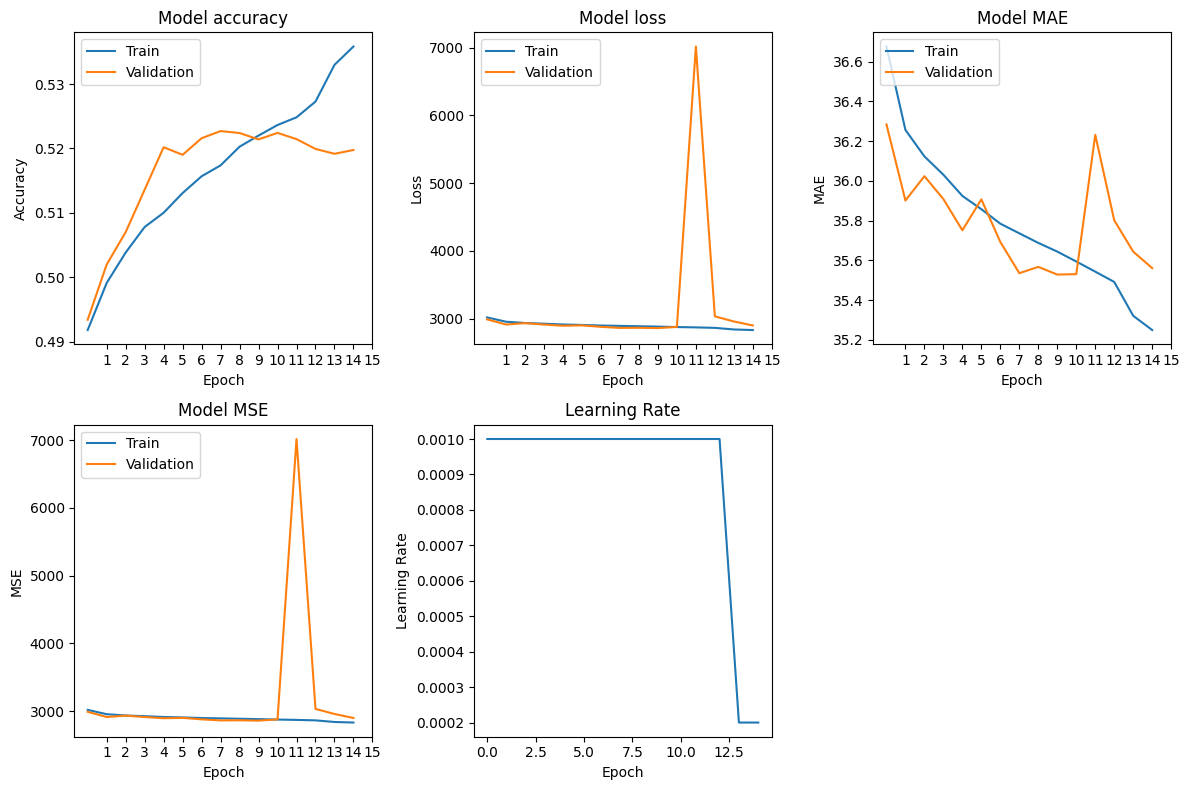

In [20]:
plot_metrics(history3)

In [21]:
# Save the entire model
custom_cnn_model3.save(SAVE_PATH + 'custom_cnn_model3.keras')

In [22]:
# Load the model from a file
# custom_cnn_model3 = tf.keras.models.load_model(SAVE_PATH + 'custom_cnn_model3.keras')
gc.collect()

20534

: 

# Hyperparameter tuning for Custom CNN 3

In [23]:
class CustomCNNHyperModel(HyperModel):
    def __init__(self, input_shape=(IMG_SIZE, IMG_SIZE, 3)):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()
        
        # First Convolutional Block
        model.add(Conv2D(hp.Int('conv_1_filters', min_value=32, max_value=128, step=32), 
                         (3, 3), activation=hp.Choice('conv_1_activation', values=['relu', 'sigmoid']), 
                         input_shape=self.input_shape))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))

        # Second Convolutional Block
        model.add(Conv2D(hp.Int('conv_2_filters', min_value=64, max_value=256, step=64), 
                         (3, 3), activation=hp.Choice('conv_2_activation', values=['relu', 'sigmoid']))),
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))

        # Third Convolutional Block
        model.add(Conv2D(hp.Int('conv_3_filters', min_value=128, max_value=512, step=128), 
                         (3, 3), activation=hp.Choice('conv_3_activation', values=['relu', 'sigmoid']))),
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))

        # Fourth Convolutional Block
        model.add(Conv2D(hp.Int('conv_4_filters', min_value=256, max_value=1024, step=256), 
                         (3, 3), activation=hp.Choice('conv_4_activation', values=['relu', 'sigmoid']))),
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))

        # Fifth Convolutional Block
        model.add(Conv2D(hp.Int('conv_5_filters', min_value=512, max_value=1024, step=512), 
                         (3, 3), activation=hp.Choice('conv_5_activation', values=['relu', 'sigmoid']))),
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        
        # Sixth Convolutional Block
        model.add(Conv2D(hp.Int('conv_6_filters', min_value=1024, max_value=2048, step=1024), 
                         (3, 3), activation=hp.Choice('conv_6_activation', values=['relu', 'sigmoid']))),
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))

        # Global Average Pooling instead of Flattening
        model.add(GlobalAveragePooling2D())

        # Fully Connected Layer with Dropout
        model.add(Dense(hp.Int('dense_units', min_value=256, max_value=1024, step=256), 
                        activation=hp.Choice('dense_activation', values=['relu', 'sigmoid']), kernel_regularizer=l2(0.001))),
        model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))

        # Output Layer
        model.add(Dense(4, activation=hp.Choice('dense_activation', values=['linear', 'sigmoid'])))  # Output layer with 4 units for bounding box coordinates (whxy)

        # Compile the model
        optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])
        learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
        if optimizer == 'adam':
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                                  loss='mse')
        elif optimizer == 'rmsprop':
            model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate),
                                  loss='mse')
        elif optimizer == 'sgd':
            model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate),
                                  loss='mse')
        return model
    
    def evaluate(self, test_dataset):
        results = self.model.evaluate(test_dataset, verbose=0)
        print(results)
        loss, acc, mse, mae, rmse = results
        # rmse = np.sqrt(mse)
        lr = self.model.optimizer.learning_rate.numpy()
        print(f'Testing Loss: {loss:.4f}, Accuracy: {acc:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, Learning Rate: {lr:.4f}')
        return {
            'loss': loss,
            'accuracy': acc,
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'learning_rate': lr
        }
    
    def save(self, path):
        self.model.save(path)

# Initialize the hypermodel
hypermodel = CustomCNNHyperModel(input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Initialize the tuner
tuner = Hyperband(
    hypermodel,
    objective='val_loss',
    # max_epochs=2, 
    max_epochs=EPOCHS,  
    factor=3, 
    directory='hyperparameter_tuning',
    project_name='custom_cnn_model',
    overwrite=True
)

# Display search space summary
tuner.search_space_summary()

# Create TensorFlow Datasets with smaller batch size
train_dataset = create_dataset(train_paths, train_bboxes, batch_size=16)
val_dataset = create_dataset(val_paths, val_bboxes, batch_size=16)
test_dataset = create_dataset(test_paths, test_bboxes, batch_size=16)

train_dataset = train_dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
val_dataset = val_dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
test_dataset = test_dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))

# Run the hyperparameter search
tuner.search(train_dataset, validation_data=val_dataset, epochs=EPOCHS)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model
best_model.evaluate(test_dataset)

# Display the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hyperparameters.values)

# Retrieve the best optimizer
best_optimizer = best_hyperparameters.get('optimizer')
print(f"Best optimizer: {best_optimizer}")


Search space summary
Default search space size: 17
conv_1_filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
conv_1_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
conv_2_filters (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 64, 'sampling': 'linear'}
conv_2_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
conv_3_filters (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 512, 'step': 128, 'sampling': 'linear'}
conv_3_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
conv_4_filters (Int)
{'default': None, 'conditions': [], 'min_value': 256, 'max_value': 1024, 'step': 256, 'sampling': 'linear'}
conv_4_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'o

In [ ]:
# Retrieve the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Extract the best learning rate if it was tuned
best_learning_rate = best_hyperparameters.values.get('learning_rate', 0.001)  # Default to 0.001 if not tuned

# Print the best learning rate to verify
print(f"Best learning rate: {best_learning_rate}")
print(best_hyperparameters.values)

# Build the model using the best hyperparameters
best_model = tuner.hypermodel.build(best_hyperparameters)

# Create the optimizer with the best learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=best_learning_rate)

# Compile the model with the optimizer
best_model.compile(optimizer=optimizer, 
                   loss='mse', 
                   metrics=['accuracy', 'mae', 'mse', tf.keras.metrics.RootMeanSquaredError(name='rmse')])

# Train the model on the full dataset
history_best = best_model.fit(train_dataset, epochs=EPOCHS, batch_size=32, validation_data=val_dataset)

# Evaluate the best model
result = best_model.evaluate(test_dataset)
print(f'Best model testing Loss: {result[0]}, Accuracy: {result[1]}, Testing MAE: {result[2]}, Testing MSE: {result[3]}, Testing RMSE: {result[4]}')

Best learning rate: 0.0003545063403315723
{'conv_1_filters': 96, 'conv_1_activation': 'relu', 'conv_2_filters': 256, 'conv_2_activation': 'relu', 'conv_3_filters': 128, 'conv_3_activation': 'sigmoid', 'conv_4_filters': 1024, 'conv_4_activation': 'sigmoid', 'conv_5_filters': 512, 'conv_5_activation': 'relu', 'dense_units': 256, 'dense_activation': 'relu', 'dropout_rate': 0.4, 'optimizer': 'sgd', 'learning_rate': 0.0003545063403315723, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
Epoch 1/20
1/1 [==============================] - 1s 865ms/step - loss: 0.5490 - accuracy: 0.1667 - mae: 0.3855 - mse: 0.2071 - rmse: 0.4550 - val_loss: 1.5856 - val_accuracy: 1.0000 - val_mae: 0.7121 - val_mse: 1.2457 - val_rmse: 1.1161
Epoch 2/20
1/1 [==============================] - 0s 149ms/step - loss: 0.4267 - accuracy: 0.8333 - mae: 0.2490 - mse: 0.0868 - rmse: 0.2946 - val_loss: 1.3714 - val_accuracy: 1.0000 - val_mae: 0.6931 - val_mse: 1.0334 - val_rmse: 1.0166
Epo

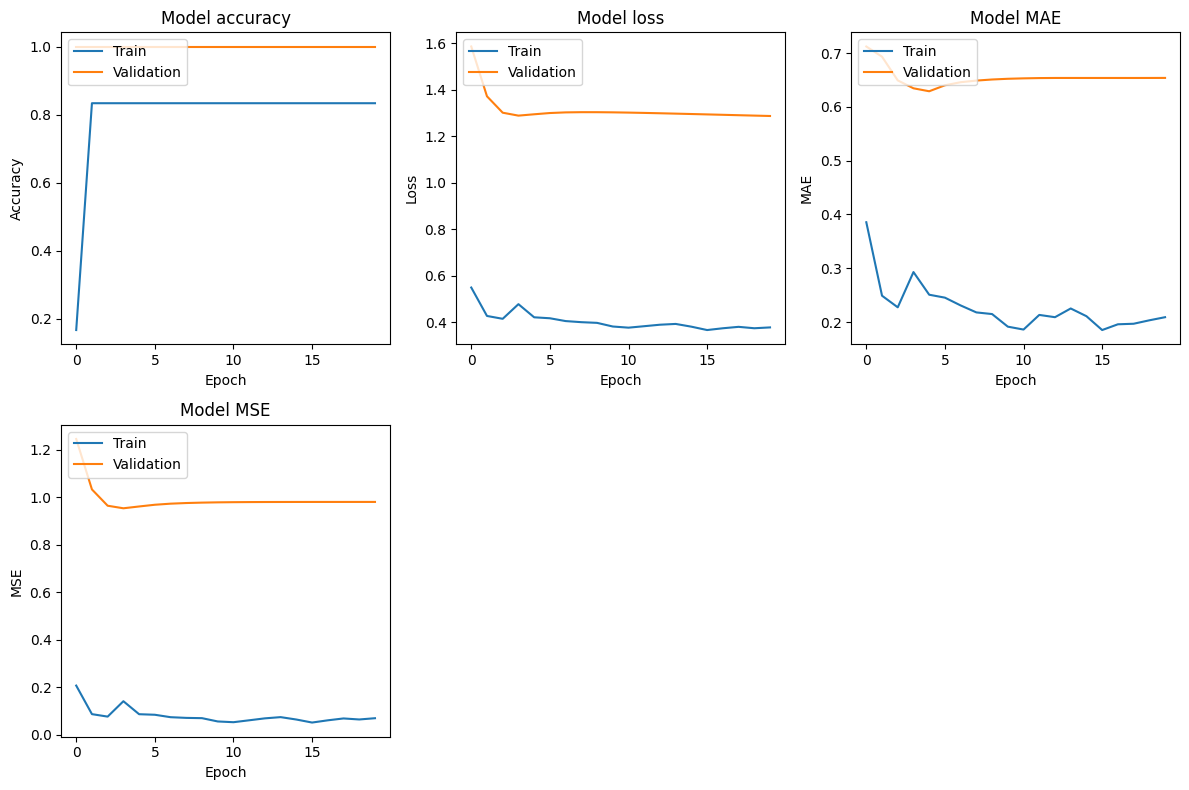

In [ ]:
plot_metrics(history_best)

In [ ]:
best_model.save(SAVE_PATH + 'best_custom_cnn_model.keras')

In [ ]:
import os

# Path to your MP3 file
mp3_file = r"C:\Users\WenShen\Documents\GitHub\That's Why I Like You.mp3"

# Use the os module to call Windows Media Player
os.system(f'start wmplayer "{mp3_file}"')

0

- hyperparameter tuning and models path zip and send to me for compile